# Lesson 4 - TensorFlow and Convolutional Neural Networks

This last lesson introduces the main development framework for Artificial Neural Networks: Google's [TensorFlow](https://www.tensorflow.org) library.
TensorFlow provides many optimization algorithms, regularization techniques, high-level abstractions (e.g. *layers*) and also logging and visualization tools collected in the [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) suite.
We will take advantage of TensorFlow's API to describe the problem of regularization and the class of Convolutional Neural Networks.

### Summary

* [TensorFlow](#tensorflow)
* [The MNIST dataset](#mnist)
* [Building a model in TensorFlow](#tfmodel)
* [Spatial locality and sparse connectivity](#sparseconnect)
* [Layers](#layers)


<a id=tensorflow></a>
### TensorFlow

TensorFlow was initially released in late 2015 to allow Machine Learning researchers to use a production-level framework for designing and testing their models.

Discussions about pros and cons with respect to other frameworks are left to dedicated [blog posts](https://deeplearning4j.org/compare-dl4j-tensorflow-pytorch).
A main point to use TensorFlow is that although it requires much effort to get confidence with, it pays off many times over due to its flexibility (passing from research models to deployment models is quite straightforward since the syntax is the same) and community support.

TensorFlow is based on the *dataflow* programming model which has been studied during the last two lessons.
This means that almost every action a programmer wants his program to do has to be thought to as an [**Operation**](https://www.tensorflow.org/api_docs/python/tf/Operation), while data is stored in [**Tensor**](https://www.tensorflow.org/api_docs/python/tf/Tensor) objects.

A tricky difference comes in when we talk about [**Variable**](https://www.tensorflow.org/api_docs/python/tf/Variable) objects: these class represents a wrapper of `tf.Operation`, `tf.Tensor` objects, and maintenance functions to allow TensorFlow to initialize, update, load and store parameters into them.
After all, what defines an Artificial Neural Network are its architecture and its parameters: maybe TensorFlow's implementation is not the most transparent one but, as already said, it comes with many advantages.


In [1]:
import tensorflow as tf
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == 'win32':
    WORKING_DIRECTORY = '.\MNIST'
elif sys.platform == 'linux':
    WORKING_DIRECTORY = './MNIST'

<a id=mnist></a>
### The MNIST dataset

The [MINST database](http://yann.lecun.com/exdb/mnist/) is a set of greyscale images of 28-by-28 pixels representing decimal digits from zero to nine.
It is composed by a training set containing 60000 examples and by a test set containing 10000 examples.

The problem is a multinomial logistic regression: a model $f_{\theta}: X \to Y$ should map images (points of $X$) to one of ten classes ($Y = \{0, 1, \dots 9\}$).

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting .\MNIST\data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting .\MNIST\data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting .\MNIST\data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting .\MNIST\data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/datas

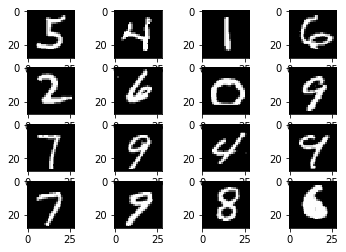

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets(os.path.join(WORKING_DIRECTORY, 'data'), one_hot=True)
# plot first 16 images
batch_x, batch_y = mnist.validation.next_batch(16)
num_rows = 4
num_cols = 4
fig1 = plt.figure()
for i in range(0, num_rows*num_cols):
    img = np.reshape(batch_x[i], (28, 28))
    fig1.add_subplot(num_rows, num_cols, i+1)
    plt.imshow(img, cmap='gray')
plt.show()


<a id=tfmodel></a>
### Building a model in TensorFlow

TensorFlow programs should leverage Python's object-orientedness.

Each `model` class should have at least a private `__build` method (called by `__init__`) and public `train` and `infer` methods:
* the `__build` method should take care of assembling the computational graph, and may be decomposed in submethods corresponding to the mathematical transformations your model has been thinked to represent;
* to make it easier for other researchers to replicate the model you build and its respective training experiment, training data consumed by the `train` method should be retrieved and loaded by a specific private procedure `__load_data`;
* in contrast, it should be possible to pass whichever compatible inputs to the `infer` method, to allow quick tests on user-provided data.

This approach allows other researchers and engineers to:
* quickly reuse functions that define specific sequences of computational nodes, representing specific mathematical transformations;
* easily reproduce your ideas;
* quickly move from a research model to a deployment one.


In [3]:
class MNISTFullyConnected():
    def __init__(self):
        # training hyperparameters
        self.learning_rate = 0.005
        self.num_epochs = 10
        self.batch_size = 16
        # architecture hyperparameters
        self.num_inputs = 784
        self.num_hidden = 40
        self.num_outputs = 10
        # build model and set up log tools
        self.logdir = os.path.join(WORKING_DIRECTORY, 'log_fc')
        self.__build(self.num_hidden)
        self.saver = tf.train.Saver()
        
    def __build(self, num_hidden):
        with tf.name_scope('input_nodes') as scope:
            self.X = tf.placeholder(tf.float32, [None, self.num_inputs], name='image')
            ########
            # TODO #
            ########
            probs = tf.nn.softmax(logits, name='probabilities')
            self.output = tf.argmax(probs, axis=1, name='prediction')
        with tf.name_scope('loss') as scope:
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                                    labels=self.Y_hat,
                                                                    name='cross_entropy')
            loss = tf.reduce_mean(cross_entropy, name='loss')
            self.loss_summary = tf.summary.scalar('loss_log', loss)
        with tf.name_scope('optimizer') as scope:
            self.lr = tf.placeholder(tf.float32, name='learning_rate')
            self.optimizer = tf.train.AdamOptimizer(self.lr).minimize(loss)
        with tf.name_scope('test') as scope:
            correct_preds = tf.equal(self.output, tf.argmax(self.Y_hat, axis=1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32), name='accuracy')
            
    def __load_data(self):
        mnist = input_data.read_data_sets(os.path.join(WORKING_DIRECTORY, 'data'), one_hot=True)
        return mnist
        
    def train(self):
        # load data
        mnist = self.__load_data()
        with tf.Session() as sess:
            with tf.summary.FileWriter(self.logdir, sess.graph) as writer:
                writer.add_graph(sess.graph)
                # initialize variables
                init_op = tf.global_variables_initializer()
                sess.run(init_op)
                num_train_batches = (len(mnist.train.images) + (self.batch_size - 1)) // self.batch_size
                for i_epoch in range(self.num_epochs):
                    # training
                    for i_batch in range(num_train_batches):
                        batch_x, batch_y_hat = mnist.train.next_batch(self.batch_size)
                        _, loss = sess.run([self.optimizer, self.loss_summary], feed_dict={self.X: batch_x,
                                                                                           self.Y_hat: batch_y_hat,
                                                                                           self.lr: self.learning_rate})
                        writer.add_summary(loss, i_epoch*num_train_batches + i_batch + 1)
                    # validation
                    valid_accuracy = sess.run(self.accuracy, feed_dict={self.X: mnist.validation.images,
                                                                        self.Y_hat: mnist.validation.labels})
                    print('Epoch: {:2d} - Validation accuracy: {:6.2f}%'.format(i_epoch+1, 100*valid_accuracy))
                # test
                test_accuracy = sess.run(self.accuracy, feed_dict={self.X: mnist.test.images,
                                                                   self.Y_hat: mnist.test.labels})
                print('Test accuracy: {:6.2f}%'.format(100*test_accuracy))
                # save model
                self.saver.save(sess, os.path.join(self.logdir, 'fc'))
        
    def infer(self, img):
        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(self.logdir)
            if ckpt is not None:
                self.saver.restore(sess, ckpt.model_checkpoint_path)
                lab = sess.run(self.output, feed_dict={self.X: img})
                plt.imshow(np.reshape(img, (28, 28)), cmap='gray', label=str(lab))
                plt.show()
                print('Predicted label: {}'.format(str(lab)))
            else:
                print('No checkpoint found: train the model before doing inference.')


As for the `deepteaching` framework, the creation and usage of an ANN model in TensorFlow must be decomposed in two steps:
* the **build** phase, during which the computational graph is assembled;
* the **runtime** phase, during which data is flown through the graph (and parameters stored in `Variable`s might be updated).

We will discuss in detail all three main methods.

#### `__build`
The first observations regard the readability of a computational graph.
Notice that almost each operation in TensorFlow implements a `name` attribute, that allows to give each node a descriptive label.
More importantly, notice the usage of *scopes*.
Scopes are **context manager** objects, i.e. Python objects that implement both a `__enter__` and an `__exit__` method.
In particular, scopes allow a user create namespaces to group together related operations, a feature that greatly increases readability of the code (and also of the graphs that can be displayed using TensorBoard).

Every input operation (`tf.placeholder`s and the `tf.Variable` objects obtained by calls to `tf.get_variable`) must declare the `shape` of their respective operands.
This is necessary for TensorFlow to automatically set up appropriate connections between operations and test the model *dimensional consistency*.
Observe that dimensions that are unknown at desing time, or that should remain flexible, can be set to `None`.
This feature is very useful for placeholders, since at training time we would like to pass them batches composed by many samples (or even try different batch sizes) but at inference time we will likely process one instance at a time.

Finally, we will focus on two operations which syntax does not allow an intuitive understanding of what's going on, since their functions will be completely clear only through their relations with the `train` and `infer` methods.

At line 43, an operation of type `tf.summary.scalar` is defined.
This can be thought at as a *watcher* of the underlying node (in this case the `loss` node, which computes the empirical loss whenever labelled data is fed to the model): an evaluation of a `tf.summary.scalar` produces a package of information in string format containing the last state of the underlying monitored node, and this string can be written to a `tf.Event` object.
`tf.Event` objects can eventually be consumed by TensorBoard to visualize summaries of all monitored operations.

The other important operation is defined at line 46, and is of type `tf.train.Optimizer`.
These operations are linked on top of operations that compute losses.
They and are much like the `Trainer` objects defined by `deepteaching`, in that they are wrappers of many smaller operations that are linked to the model.
When a `tf.train.Optimizer` is evaluated, all its small operations are executed using two main methods:
* `compute_gradients`, which monitors the underlying loss operation state and compute its respective error signals directed to the parameters stored in `tf.Variable`s;
* `apply_gradients`, which implements a gradient descent algorithms using the previously computed error signals.

A `minimize` method is also available, and is a wrapper that executes these two operations one after the other.

#### `train`
Pushing data through a graph in TensorFlow can happen only during `tf.Session`s.

`tf.Session`s are context managers which most important method is `run`: this method is of capital importance for TensorFlow programs, since it consumes a list of `tf.Operation`s and a dictionary (called `feed_dict`) associating `tf.placeholder`s to their fed values, and returns `numpy` arrays containing the state of the passed operations after the evaluation.
`run` is able to compute operations dynamically: it does not compute unuseful operations, and requires to feed only the placeholders which state is required to compute the desired values.
For instance, suppose we want to run just an evaluation of the accuracy on the validation set: `loss` and `self.optimizer` are not required then, and since `self.lr` placeholder is required only by `self.optimizer` there is no need to feed this placeholder.

`tf.summary.FileWriter`s are context managers which allow to monitor a `tf.Graph` passed to them at their creation.
They can call a `add_graph` method to write a compact description of the monitored graph to a `tf.Event` (line 60).
Notice that whenever a `tf.summary.scalar` operation is evaluated during a call to `tf.Session().run` (line 69), the output string tensor can be written to a `tf.Event` calling `tf.summary.FileWriter.add_summary` method (line 72).
All the `tf.Event` objects are messages that can be converted to **protobuf** files (protobuf is Google's language-agnostic, platform-agnostic meta-language to describe computational entities), which can be consumed by TensorBoard for visualization purposes.

Finally, `tf.train.Saver()` are context managers that can save and restore TensorFlow models (their architectures and parameters values).
Notice that this object is added to the model after it has been built (line 14), and is called only once training has finished (line 82).
This last choice is not a constraint of TensorFlow, which allows instead to choose criteria for checkpointing.
Our choice to save the model only at the end of training is just to keep the code as simple as possible for didactic purposes.

#### `infer`
The first action of this method is to look for information about a trained model (`tf.train.get_checkpoint_state` method).
If such data is found, the corresponding model is loaded into the current `tf.Session()` and the inferential part of the graph is run: an input observation `img` is fed to the placeholder `self.X`, and all operations up to `self.output` are then evaluated by the call to `run`.

We can now instantiate a model and train it.


In [4]:
mnist_fc = MNISTFullyConnected()
mnist_fc.train()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Extracting .\MNIST\data\train-images-idx3-ubyte.gz
Extracting .\MNIST\data\train-labels-idx1-ubyte.gz
Extracting .\MNIST\data\t10k-images-idx3-ubyte.gz
Extracting .\MNIST\data\t10k-labels-idx1-ubyte.gz
Epoch:  1 - Validation accuracy:  93.30%
Epoch:  2 - Validation accuracy:  93.92%
Epoch:  3 - Validation accuracy:  94.68%
Epoch:  4 - Validation accuracy:  95.04%
Epoch:  5 - Validation accuracy:  95.62%
Epoch:  6 - Validation accuracy:  95.56%
Epoch:  7 - Validation accuracy:  95.72%
Epoch:  8 - Validation accuracy:  96.02%
Epoch:  9 - Validation accuracy:  95.46%
Epoch: 10 - Validation accuracy:  95.84%
Test accuracy:  95.96%


To verify that our TensorFlow model was properly trained, we can test it on the first instance of the batch showed above.


INFO:tensorflow:Restoring parameters from .\MNIST\log_fc\fc


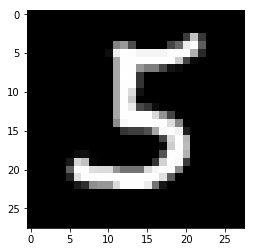

Predicted label: [5]
Real label: 5


In [5]:
mnist_fc.infer(batch_x[0][None, :])
print('Real label: {}'.format(str(np.argmax(batch_y[0]))))

TensorBoard allows to inspect all the events that have been recorded by a `tf.summary.FileWriter()` object.
In this example, we will refer to the directory containing logs as `log_dir` and to the path to the directory containing it as the `WORKING_DIRECTORY`.

First, navigate to the `WORKING_DIRECTORY`:
```
$ cd WORKING_DIRECTORY
```

then activate TensorBoard issuing
```
$ tensorboard --logdir=log_dir
```

This command should print on the terminal a URL: navigating to this URL using a browser should open the TensorBoard visualization tool, that you can explore following the [official guide](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard).

<a id=sparseconnect></a>
### Spatial locality and sparse connectivity

The fundamental mathematical concept to understand Convolutional Neural Networks is that of **test function**.
Formally, a test function is a map

$$\Psi: \mathbb{R}^n \to \mathbb{R}$$

which is **smooth**, i.e. $\Psi \in \mathcal{C}^{\infty}(\mathbb{R}^n)$, and **compactly supported**, i.e. the set $\mathcal{S}_{\Psi} = \{x \in \mathbb{R}^n | \Psi(x) \neq 0\}$ is a compact subset of $\mathbb{R}^n$.

The key property which regards CNNs is the second, the compact support property.
An important result of real analysis states that a subset $\mathcal{S}_{\Psi} \subset \mathbb{R}^n$ is compact if and only if it is bounded: there exists a ball of radius $\rho \in \mathbb{R}^{+}$ such that $\mathcal{S}_{\Psi}$ is contained in such a ball, i.e. $\|x\| \leq \rho, \forall x \in \mathcal{S}_{\Psi}$.

To keep things simple, imagine to close your eyes and run a hand of yours on a coarse surface.
Clearly, if the surface is sufficiently wide you just can't feel it all under your hand (i.e. your hand is a compactly supported function) and at any fixed time step and position you receive zero information about the coarsness of the part of surface that's outside your hand; but you are *testing* the part of surface that's beneath your hand and getting **local information** about the surface!
Hence the name of test functions.

The capital importance of test functions is their regularizing property.
In fact, just like the hand of yours of the comparison, test functions can be slided all along the tested spaces and reveal bumps, cavities, or also *averagely flat* zones: this information is extracted by multiplying the test function with the underlying region in **convolution** or **cross-correlation** operations.
Let $h(x)$ be a function measuring a quantity, and let $\Psi(t)$ be a test function.
A useful feature map $\xi(h(x))$ which extracts information from $h$ can be obtained using a convolution:

$$\begin{align} \xi(h(x)) &= \Psi(t) * h(x) \\ &= \int_{\mathbb{R}^n} \Psi(t) h(x-t) dt \end{align}$$

while another feature $\phi(h(x))$ can be obtained using the slightly different cross-correlation:

$$\begin{align} \phi(h(x)) &= \Psi(t) * h(x) \\ &= \int_{\mathbb{R}^n} \Psi(t) h(x+t) dt \end{align}$$

In CNNs jargon, the operation performed by every feature map in every convolutional layer is actually a cross-correlation, although it is improperly named *convolution*.
From now on, we will refer to cross-correlation with this improper name of *convolution*.

<img src='figures/test_functions.png', width=480, height=480></img>

The figure above represents a test function $\Psi$ (dark cyan) being slided on a tested function $h$ (black).
In the case of continuous functions, the convolution operation should be performed by placing the *center* of the test function (think of it as the top of the Gaussian bell in the figure above) on each point $x$ in the domain of $h$, and then performing the convolutional integral above.
We observe now that the integral represents a **summation over all possible weighted products $\Psi(t)h(x+t)dt$**, since this notion allows to understand the interpretaion of **discrete filters** employed by convolutional transformations.

From a computer's perspective, no notion of a continuous function can be defined.
The signals processed by an ANN, such as its internal features $h(x)$, are always discrete signals, almost always the result of sampling from a real *analog signal* such as a light or audio wave.
Due to the finiteness of a computer's memory, more than discrete, each input signal $h$ is represented by a finite array, while each test function can be converted into a **discrete filter** following a similar [sampling procedure](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem).
From now on, we will refer to these finite discrete filters simply as filters or **kernels**, meaning a discretization of an appropriate test function.
The result of the discretization of the incoming signal $h$ and the test function $\Psi$ is depicted in the figure below.

<img src='figures/test_functions_discrete.png', width=480, height=480></img>

We can see that the continuous integral is converted into a finite sum of products.
These products multiply the non-zero components of a small vector (the filter) with the corresponding underlying elements of the discrete input signal.
The number of non-zero components of the filter array is called the **kernel size**.

A first important consequence of discretization are the constraint of the filter positions.
We said before that in symbolic integral expressions the test function $\Psi$ must be centered at every point $x$ in the domain of $h$ to evaluate the transform.
Clearly, in a discrete domain this is possible only for discrete *jumps* of the filter.
The length of these jumps is called **stride** of the convolution.
Since both the input array and the filter array are finite, and since the filter must be convolved with elements of the input (remember that the goal of a convolution is to extract information from the underlying signal), the filter can be placed only in certain positions.
This problem is usually solved in one of two ways:
* with a `VALID` padding, where the left-element of the filter array is *placed* against the left-hand of the input array, and then is moved towards the right-hand of the input array by discrete jumps of size equal to `stride`, but stopping when another jump would overlap a non-zero element of the filter with an element outside the input array; supposing the input has length $i$, the kernel has size $k$ and the stride is $s$, the number of possible positions on which the filter can be placed is $o = \lfloor \frac{i-k}{s} \rfloor + 1$;

<img src='figures/valid_padding.png', width=480, height=480></img>

* with a `SAME` padding, where we choose an element of the filter array as a *centre*, then place this element on top of the leftmost element of the input array, then move the filter rightward until the *centre* would fall upon an element which is outside the input array; clearly, this procedure might require to **pad** the input array with *fake elements* representing noise from outside the input itself; supposing again the input has length $i$, the kernel has size $k$ and the stride is $s$, the number of possible positions on which the filter can be placed is $\o = \lfloor \frac{i-1}{s} \rfloor + 1$.

<img src='figures/same_padding.png', width=480, height=480></img>

The natures of these two *padding schemes* answer to different situations.
The `VALID` scheme introduces no *artificial* knowledge into the representation, but the number of positions on which the filter can be placed is no more than the number of elements in the input array; thus, this scheme leads to a **compression of the input** to a more compact feature array $\phi$.
The `SAME` scheme allows to place the most relevant part of a filter, its *centre*, also on the border of the input array, treating them as full-dignity array elements, where the `VALID` scheme would consider them only when they fall under the *tails* of the filter; but the price to extract information from the border is to arbitrarily add noisy context around the input array, the *padding*.
As a sidenote: the name `SAME` comes from the fact that if we choose a filter stride of $s = 1$ for this scheme, the output array dimension $o$ is equal to the input array dimension $i$ (to make sure, just look at the equation above).

A filter can be thought also as an array of the same size as the input array, but with many components set to zero.
This property is known as **sparsity**.

<img src='figures/sparse_connectivity.png', width=480, height=480></img>

Convolving the same filter over different positions of an input array can thus be seen as a vector-matrix multiplication where the vector is the input array and the matrix is composed by sparse column vectors (the filter), where equally-valued elements are placed at different positions to match the corresponding underlying convolving window of the input signal.

Extending this concept to two- or more-dimensional input arrays is not too difficult, since each array can be *unrolled* into a vector, and two- or more-dimensional filters can be suitably *unrolled* themselves.
The image below depicts how an image with only one channel can be vectorized (assuming it has a [row-major memory layout](https://en.wikipedia.org/wiki/Row-_and_column-major_order)), convolved with two-dimensional filters (vectorized themselves), and then *repacked* into a two-dimensional image.

<img src='figures/vectorized_convolutions.png', width=480, height=480></img>


<a id=layers></a>
### Layers

TensorFlow provides a higher level, important abstraction over operations and variables.

As the name says, a **layer** is an entity that is to be laid upon something else: it collects all the `Variable`s and `Operation`s needed to perform a desired high level mathematical transformation *upon* a previous feature $x$.
For instance, it can implement a linear transformation followed by sigmoid activation

$$\phi(x) = \sigma(xW + b)$$

with a simple command

```
tf.layers.dense(x, num_units, activation=tf.nn.sigmoid, kernel_initializer=tf.truncated_normal_initializer())
```

where we suppose `x` to be an input tensor/operation.

<img src='figures/dataflow_implementation_Layer.png', width=480, height=480></img>

In the *dataflow* paradigm visualization we can think to layers as wrappers of simpler operations, as shown by the figure above: the first yellow layer implements an affine transformation (without activation) $s = xW + b$, the red layer implements a sigmoid activation of the score $h = \sigma(s)$ while the last yellow layer performs a linear transformation $y = hW$ (no bias addition).

The high-level view enabled by `layers` objects enormously increases modelling capabilities of researchers: it sacrifices computational efficiency (which better fits deployment requirements) for mathematical expressiveness.

We will now use these classes to implement a Convolutional Neural Network to solve the MNIST multinomial regression task.


In [1]:
class MNISTConvolutional():
    def __init__(self):
        # training hyperparameters
        self.learning_rate = 0.005
        self.num_epochs = 10
        self.batch_size = 16
        # architecture hyperparameters
        self.num_inputs = 784
        self.num_features_conv_1 = 16
        self.num_features_conv_2 = 32
        self.num_features_conv_3 = 64
        self.num_hidden = 100
        self.keep_prob = 0.5
        self.num_outputs = 10
        # build model and set up log tools
        self.logdir = os.path.join(WORKING_DIRECTORY, 'log_cnn')
        self.__build()
        self.saver = tf.train.Saver()
    
    def __build(self):
        with tf.name_scope('input_nodes') as scope:
            self.X = tf.placeholder(tf.float32, [None, self.num_inputs], name='raw_image')
            x = tf.reshape(self.X, shape=[-1, 28, 28, 1], name='image')
            self.Y_hat = tf.placeholder(tf.int32, [None, self.num_outputs], name='label')
        with tf.variable_scope('conv') as scope:
            conv1 = tf.layers.conv2d(inputs=x,
                                     filters=self.num_features_conv_1,
                                     kernel_size=[3, 3],
                                     padding='SAME',
                                     activation=tf.nn.relu,
                                     name='conv1')
            avg1 = tf.layers.average_pooling2d(inputs=conv1,
                                               pool_size=[2, 2],
                                               strides=[2, 2],
                                               padding='VALID',
                                               name='avg1')
            conv2 = tf.layers.conv2d(inputs=avg1,
                                     filters=self.num_features_conv_2,
                                     kernel_size=[3, 3],
                                     padding='SAME',
                                     activation=tf.nn.relu,
                                     name='conv2')
            avg2 = tf.layers.average_pooling2d(inputs=conv2,
                                               pool_size=[2, 2],
                                               strides=[2, 2],
                                               padding='VALID',
                                               name='avg2')
            conv3 = tf.layers.conv2d(inputs=avg2,
                                     filters=self.num_features_conv_3,
                                     kernel_size=[3, 3],
                                     padding='SAME',
                                     activation=tf.nn.relu,
                                     name='conv3')
            avg3 = tf.layers.average_pooling2d(inputs=conv3,
                                               pool_size=[7, 7],
                                               strides=[1, 1],
                                               padding='VALID',
                                               name='avg3')
        with tf.variable_scope('hidden_features') as scope:
            dense = tf.layers.dense(tf.layers.flatten(avg3), self.num_hidden, activation=tf.nn.relu, name='dense')
            self.kp = tf.placeholder(tf.float32, name='dropout_prob')
            dropout = tf.layers.dropout(dense, self.kp, training=True, name='dropout')
        with tf.variable_scope('output_layer') as scope:
            logits = tf.layers.dense(dropout, self.num_outputs, name='logits')
            probs = tf.nn.softmax(logits, name='probabilities')
            self.output = tf.argmax(probs, axis=1, name='prediction')
        with tf.name_scope('loss') as scope:
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                                    labels=self.Y_hat,
                                                                    name='cross_entropy')
            loss = tf.reduce_mean(cross_entropy, name='loss')
            self.loss_summary = tf.summary.scalar('loss_log', loss)
        with tf.name_scope('optimizer') as scope:
            self.lr = tf.placeholder(tf.float32, name='learning_rate')
            self.optimizer = tf.train.AdamOptimizer(self.lr).minimize(loss)
        with tf.name_scope('test'):
            correct_preds = tf.equal(self.output, tf.argmax(self.Y_hat, axis=1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32), name='accuracy')
    
    def __load_data(self):
        mnist = input_data.read_data_sets(os.path.join(WORKING_DIRECTORY, 'data'), one_hot=True)
        return mnist
        
    def train(self):
        # load data
        mnist = self.__load_data()
        with tf.Session() as sess:
            with tf.summary.FileWriter(self.logdir, sess.graph) as writer:
                writer.add_graph(sess.graph)
                # initialize variables
                init_op = tf.global_variables_initializer()
                sess.run(init_op)
                num_train_batches = (len(mnist.train.images) + (self.batch_size - 1)) // self.batch_size
                for i_epoch in range(self.num_epochs):
                    ########
                    # TODO #
                    ########
                # test
                test_accuracy = sess.run(self.accuracy, feed_dict={self.X: mnist.test.images,
                                                                   self.Y_hat: mnist.test.labels,
                                                                   self.kp: 0.0})
                print('Test accuracy: {:6.2f}%'.format(100*test_accuracy))
                # save model
                self.saver.save(sess, os.path.join(self.logdir, 'cnn'))
        
    def infer(self, img):
        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(self.logdir)
            if ckpt is not None:
                self.saver.restore(sess, ckpt.model_checkpoint_path)
                lab = sess.run(self.output, feed_dict={self.X: img, self.kp: 0.0})
                plt.imshow(np.reshape(img, (28, 28)), cmap='gray', label=str(lab))
                plt.show()
                print('Predicted label: {}'.format(str(lab)))
            else:
                print('No checkpoint found: train the model before doing inference.')
    

IndentationError: expected an indented block (<ipython-input-1-2e0518ac7acd>, line 97)

We briefly describe the implementation of the current Convolutional Neural Network.

Our implementation consists of three convolutions interleaved with average pooling layers, followed by two fully connected layers.
Between these last two layers, dropout has been inserted for regularization purposes.
The *geometry* of the model can be briefly summarized as:
* $(28, 28, 1) \to (28, 28, 16)$, using $[(3\cdot3)+1]\cdot16 = 160$ parameters;
* $(28, 28, 16) \to (14, 14, 16)$, using no parameters;
* $(14, 14, 16) \to (14, 14, 32)$, using $[(3\cdot3\cdot16)+1]\cdot32 = 460$ parameters;
* $(14, 14, 32) \to (7, 7, 32)$, using no parameters;
* $(7, 7, 32) \to (7, 7, 64)$, using $[(3\cdot3\cdot32)+1]\cdot64 = 18496$ parameters;
* $(7, 7, 64) \to (1, 1, 64)$, using no parameters;
* $(64) \to (100)$, using $(64+1)\cdot100 = 6500$ parameters;
* $(100) \to (10)$, using $(100+1)\cdot10 = 1010$ parameters;

yielding a total of $160+460+18496+6500+1010 = 26626$ parameters.

To give a better intuition of the *shape* of these transformations, we report a pictorial representation of the famous [*AlexNet* model](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), the work that triggered Deep Learning research in 2012 by unveiling the enormous statistical capabilities of Artificial Neural Networks enabled by parallel hardware.

<img src='figures/alexnet.png', width=480, height=480></img>

The `train` and `infer` methods are almost the same as those of the fully connected model, taking care only to feed an appropriate value to the `self.kp` placeholder that regulates the *aggressiveness* of the dropout between the last two layers.


In [7]:
mnist_cnn = MNISTConvolutional()
mnist_cnn.train()

Extracting .\MNIST\data\train-images-idx3-ubyte.gz
Extracting .\MNIST\data\train-labels-idx1-ubyte.gz
Extracting .\MNIST\data\t10k-images-idx3-ubyte.gz
Extracting .\MNIST\data\t10k-labels-idx1-ubyte.gz
Epoch:  1 - Validation accuracy:  93.04%
Epoch:  2 - Validation accuracy:  95.10%
Epoch:  3 - Validation accuracy:  94.98%
Epoch:  4 - Validation accuracy:  96.86%
Epoch:  5 - Validation accuracy:  95.86%
Epoch:  6 - Validation accuracy:  97.50%
Epoch:  7 - Validation accuracy:  96.52%
Epoch:  8 - Validation accuracy:  97.08%
Epoch:  9 - Validation accuracy:  97.40%
Epoch: 10 - Validation accuracy:  97.70%
Test accuracy:  97.54%


The training procedure reveals an accuracy comparable to that of the shallow ANN implemented above.

But this *domain knowledge exploitation*, that leverages the intrinsic local structure of visual data, allowed a great saving in terms of number of parameters of the model.
In fact, the fully connected model with forty hidden neurons used $(784+1)\cdot40 + (40+1)\cdot10 = 31410$ parameters, while the Convolutional one, using $26626$, is about $\frac{31410-26626}{31410} * 100\% \approx 15\%$ cheaper!

INFO:tensorflow:Restoring parameters from .\MNIST\log_cnn\cnn


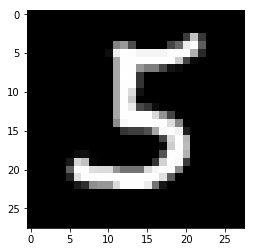

Predicted label: [5]
Real label: 5


In [8]:
mnist_cnn.infer(batch_x[0][None, :])
print('Real label: {}'.format(str(np.argmax(batch_y[0]))))

### References

**TensorFlow**: [Stanford's course](http://web.stanford.edu/class/cs20si/) on *TensorFlow for Deep Learning research* is accurate, complete and comes along with a nice [GitHub repository](https://github.com/chiphuyen/stanford-tensorflow-tutorials).
